# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1_IhEcdFQq94YT6hIqRcZtV_u4MXk1GG-?usp=sharing

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
print_ham = True
for line in open('SMSSpamCollection'):
    if line.split()[0] == "ham" and print_ham:
      print("1) Ham example: ", line[4:])
      print("The corresponding label is: ", line.split()[0])
      print_ham = False
    elif line.split()[0] == "spam":
      print("2) Spam example: ", line[4:])
      print("The corresponding label is: ", line.split()[0])
      break

1) Ham example:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

The corresponding label is:  ham
2) Spam example:  	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

The corresponding label is:  spam


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
count_spam = 0
count_ham = 0
for line in open('SMSSpamCollection'):
    if line.split()[0] == "spam":
      count_spam += 1
    else:
      count_ham += 1

print("The number of spam messages:", count_spam)
print("The number of ham messages:", count_ham)

The number of spam messages: 747
The number of ham messages: 4827


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**ANSWER:**

**Advantage:** 

1) The vocabulary is much smaller and would require less memory, and the computational cost would be low hence resulting in faster inference. 

2) Can take mis-spelling into consideration by treating them as special "unknown" token.

**Disadvantage:**

1) More tokens for one data sample, requires bigger hidden layer, thus making the model more complex and in addition it needs to learn the spelling of words as well.
             
2) The accuracy is would be lower than a word-based problem.



### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field =  torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field =  torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)



print(dataset[0].sms)
print(dataset[0].label) 
train, valid, test = dataset.split([0.6, 0.2, 0.2], True) # reshuffle = True
len(train), len(test)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0


(3343, 1114)

In [ ]:
# Spliting the dataset for Part B as well to prevent data leakage. Now the same dataset will be used in Part A and B for training and testing
import pandas as pd
# Function to convert tabulardata to dataframe
def convert2df(data):
  label = np.zeros(len(data))
  text = np.empty([len(data)], dtype='<U100')
  for i in range(0, len(data)):
    label[i], text[i] = vars(data[i]).get('label'), vars(data[i]).get('sms')
  
  df = pd.DataFrame({'target': label, 'text': text})
  return df

In [ ]:
# Train, Valid and Test sets (60,20,20) split
df_trn = convert2df(train)
df_val = convert2df(valid)
df_test = convert2df(test)

3343


In [ ]:
# Replaceing the labels in the target from 0-ham and 1-spam
df_val['target'].replace(0,'ham',inplace=True)
df_val['target'].replace(1,'spam',inplace=True)
df_trn['target'].replace(0,'ham',inplace=True)
df_trn['target'].replace(1,'spam',inplace=True)
df_test['target'].replace(0,'ham',inplace=True)
df_test['target'].replace(1,'spam',inplace=True)

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6
len(train)


6031

**ANSWER:**

The dataset needs to be balanced; otherwise, the model would predict all SMS as ham, and it would even get a high accuracy score as the majority of SMS is ham. However, the score would not accurately indicate the model's performance as it's just labeling all the SMS's as ham, including the spam. So it is crucial to have a balanced dataset so that the model can generalize well and doesn't skew to one class over the other.  


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f9ff2513c90>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'v': 30, 'E': 31, '5': 32, 'S': 33, 'C': 34, 'I': 35, 'O': 36, '7': 37, '4': 38, 'x': 39, 'A': 40, 'N': 41, '3': 42, '6': 43, '!': 44, 'R': 45, ',': 46, '9': 47, 'W': 48, 'P': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, 'G': 56, 'Y': 57, '/': 58, 'F': 59, "'": 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, '*': 71, ')': 72, ';': 73, 'J': 74, '+': 75, '(': 76, 'Q': 77, '"': 78, 'q': 79, '#': 80, '>': 81, '=': 82, '@': 83, 'ü': 84, 'Z': 85, '$': 86, 'Ü': 87, '%': 88, '_': 89, '\x92': 90, '|': 91, '‘': 92, '[': 93, ']': 94, '<': 95, '¡': 96, '“': 97, '…':

**ANSWER:**

1) **text_field.vocab.stoi** is a collections.defaultdict instance mapping token strings to numerical identifiers. That is, mapping every character to a number.


2) **text_field.vocab.itos** is a list of token strings indexed by their numerical identifiers. That is, the list of characters in stoi with the same order.

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**ANSWER:**
                   
 1) **"unk"** The string token is used to represent OOV words or unknown words.
 
 2) **"pad"** The string token is used to represent padding, because when the model is training in batches, all sequences in the batch should have the same length, the padding will be used if the sequence of character has smaller length than the maximum length.


### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
count = 1
for batch in train_iter:
# This is looped through the first 10 batches.
    if count>10:
      break
    else:
      print("Batch number is:", count, "The maximum length is:", int(batch.sms[1][0]))
      sum = 0
      # Looping through each of the 32 sms's in a batch
      for message in range(0, len(batch.sms[1])):
        #Batch.sms[1][0] always represents the maximium length so we are subtracting it with the next message length to see how many pads are there. 
        sum = sum + batch.sms[1][0] - batch.sms[1][message]
      print("For batch:", count, "The number of <pad> is:", int(sum))
      count = count+1


Batch number is: 1 The maximum length is: 183
For batch: 1 The number of <pad> is: 211
Batch number is: 2 The maximum length is: 29
For batch: 2 The number of <pad> is: 16
Batch number is: 3 The maximum length is: 157
For batch: 3 The number of <pad> is: 0
Batch number is: 4 The maximum length is: 159
For batch: 4 The number of <pad> is: 0
Batch number is: 5 The maximum length is: 40
For batch: 5 The number of <pad> is: 13
Batch number is: 6 The maximum length is: 155
For batch: 6 The number of <pad> is: 0
Batch number is: 7 The maximum length is: 27
For batch: 7 The number of <pad> is: 24
Batch number is: 8 The maximum length is: 134
For batch: 8 The number of <pad> is: 15
Batch number is: 9 The maximum length is: 48
For batch: 9 The number of <pad> is: 24
Batch number is: 10 The maximum length is: 153
For batch: 10 The number of <pad> is: 0


## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors


tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
# Input size of the text to be fed to the model
input_size = len(text_field.vocab.itos)
print(input_size)
# To run the model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

113


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "RNN"
        super(RNN, self).__init__()
        self.emb = torch.eye(input_size).to(device)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x].to(device)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Passing the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
class RNN_max(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "RNN_max"
        super(RNN_max, self).__init__()
        self.emb = torch.eye(input_size).to(device)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x].to(device)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the RNN through a max-pool layer
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
class RNN_con(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "RNN_con"
        super(RNN_con, self).__init__()
        self.emb = torch.eye(input_size).to(device)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes) # Adding another fully connected layer
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x].to(device)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # print('The first shape',torch.Tensor.size(out))
        # Concatenating the max-pooling and average-pooling of the RNN outputs
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "GRU"
        super(GRU, self).__init__()
        self.emb = torch.eye(input_size).to(device)
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x].to(device)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the GRU
        out, _ = self.gru(x, h0)
        # print('The first shape',torch.Tensor.size(out))
        # Concatenating the max-pooling and average-pooling of the GRU outputs
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "LSTM"
        super(LSTM, self).__init__()
        self.emb = torch.eye(input_size).to(device)
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
     
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x].to(device)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # set an initial cell state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0,c0))
        # print('The first shape',torch.Tensor.size(out))
        # Concatenating the max-pooling and average-pooling of the LSTM outputs
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
class LSTM_drop(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "LSTM_drop"
        super(LSTM_drop, self).__init__()
        self.emb = torch.eye(input_size).to(device)
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.drop = nn.Dropout(0.4) # Adding a dropout layer
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x].to(device)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # set an initial cell state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0,c0))
        # print('The first shape',torch.Tensor.size(out))
        # Concatenating the max-pooling and average-pooling of the LSTM outputs
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc1(self.drop(out)) # Implementing the dropout on the first fully connected layer
        out = self.fc2(out)
        return out

## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data, batch_size):

    data_loader = torchtext.legacy.data.BucketIterator(data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                 # repeat the iterator for many epochs
    
    model.eval()
    correct, total = 0, 0
    for message, labels in data_loader:
        output = model(message[0].to(device))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred).to(device)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def train_rnn_network(model, train, valid, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    train_loader = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)     
    valid_loader = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)

    for epoch in range(num_epochs):
        model.train()
        # The training loop
        for message, labels in train_loader:
            optimizer.zero_grad()
            pred = model(message[0].to(device))
            loss = criterion(pred, labels.to(device))
            loss.backward()
            optimizer.step()
        train_losses.append(float(loss))
         # Validation loop
        for message, labels in valid_loader:
            pred = model(message[0].to(device))
            loss = criterion(pred, labels.to(device))
        valid_losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train, batch_size))
        valid_acc.append(get_accuracy(model, valid, batch_size))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (epoch+1, loss, train_acc[-1], valid_acc[-1]))
        # Saving the model for every 5 epochs and at the last epoch 
        if epoch % 5 == 0 or epoch == num_epochs:
          model_path = "/content/model_{0}".format(model.name)
          torch.save(model.state_dict(), model_path)

 # Plotting the Training and Validation curves wrt Epoch and Loss
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
# Training and Validation curves wrt Epoch and Accuracy
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

Epoch 1; Loss 0.651670; Train Acc 0.526281; Val Acc 0.861883
Epoch 2; Loss 0.690052; Train Acc 0.532084; Val Acc 0.861883
Epoch 3; Loss 0.652590; Train Acc 0.543359; Val Acc 0.859193
Epoch 4; Loss 0.695398; Train Acc 0.555795; Val Acc 0.858296
Epoch 5; Loss 0.689407; Train Acc 0.571879; Val Acc 0.856502
Epoch 6; Loss 0.650492; Train Acc 0.595755; Val Acc 0.854709
Epoch 7; Loss 0.655809; Train Acc 0.609849; Val Acc 0.852915
Epoch 8; Loss 0.699538; Train Acc 0.630575; Val Acc 0.850224
Epoch 9; Loss 0.655602; Train Acc 0.645001; Val Acc 0.844843
Epoch 10; Loss 0.664956; Train Acc 0.660587; Val Acc 0.843946
Epoch 11; Loss 0.660950; Train Acc 0.672691; Val Acc 0.843946
Epoch 12; Loss 0.687158; Train Acc 0.693252; Val Acc 0.841256
Epoch 13; Loss 0.655883; Train Acc 0.713149; Val Acc 0.842152
Epoch 14; Loss 0.657114; Train Acc 0.721771; Val Acc 0.834978
Epoch 15; Loss 0.656119; Train Acc 0.725750; Val Acc 0.833184
Epoch 16; Loss 0.656436; Train Acc 0.732383; Val Acc 0.832287
Epoch 17; Loss 0.

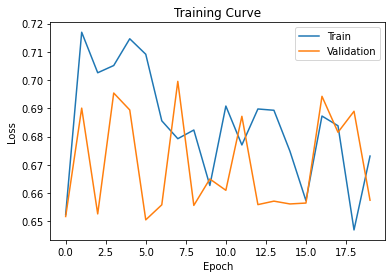

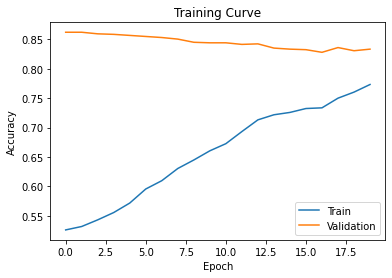

In [ ]:
# Model 1 RNN with out = self.fc(out[:, -1, :])
# h_size = 100, epochs = 20, lr = 0.00001
model = RNN(input_size, hidden_size = 100, num_classes = 2).to(device)   
train_rnn_network(model, train, valid, batch_size = 64, num_epochs = 20, learning_rate = 1e-5)

This model isn't performing well as the validation accuracy is higher than the training.

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; Loss 0.403475; Train Acc 0.788426; Val Acc 0.864574
Epoch 2; Loss 0.664028; Train Acc 0.791245; Val Acc 0.878924
Epoch 3; Loss 0.198074; Train Acc 0.906815; Val Acc 0.929148
Epoch 4; Loss 0.882360; Train Acc 0.910131; Val Acc 0.920179
Epoch 5; Loss 0.402980; Train Acc 0.887581; Val Acc 0.852915
Epoch 6; Loss 0.703955; Train Acc 0.673520; Val Acc 0.466368
Epoch 7; Loss 0.097363; Train Acc 0.931355; Val Acc 0.955157
Epoch 8; Loss 0.617008; Train Acc 0.766540; Val Acc 0.714798
Epoch 9; Loss 0.340264; Train Acc 0.916598; Val Acc 0.932735
Epoch 10; Loss 0.128623; Train Acc 0.898690; Val Acc 0.969507
Epoch 11; Loss 0.186080; Train Acc 0.923396; Val Acc 0.973094
Epoch 12; Loss 0.267048; Train Acc 0.930028; Val Acc 0.972197
Epoch 13; Loss 0.654659; Train Acc 0.742497; Val Acc 0.668161
Epoch 14; Loss 0.546542; Train Acc 0.505057; Val Acc 0.499552
Epoch 15; Loss 0.781541; Train Acc 0.483668; Val Acc 0.493274
Epoch 16; Loss 0.692097; Train Acc 0.703698; Val Acc 0.460090
Epoch 17; Loss 0.

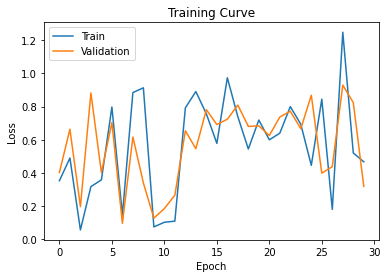

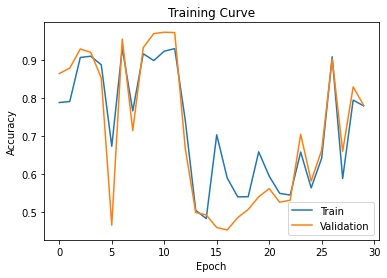

In [ ]:
# Model 2 RNN with out = self.fc(out[:, -1, :])
# h_size = 250, epochs = 30, lr = 0.001
model = RNN(input_size, hidden_size = 250, num_classes = 2).to(device)   
train_rnn_network(model, train, valid, batch_size = 64, num_epochs = 30, learning_rate = 1e-3)

This is better than before but the accuracy score is too low on both training and validation.

Epoch 1; Loss 0.322351; Train Acc 0.909468; Val Acc 0.979372
Epoch 2; Loss 0.170579; Train Acc 0.956392; Val Acc 0.943498
Epoch 3; Loss 0.060732; Train Acc 0.963688; Val Acc 0.959641
Epoch 4; Loss 0.038941; Train Acc 0.945946; Val Acc 0.978475
Epoch 5; Loss 0.075805; Train Acc 0.969657; Val Acc 0.973094
Epoch 6; Loss 0.061869; Train Acc 0.970486; Val Acc 0.957848
Epoch 7; Loss 0.165935; Train Acc 0.967004; Val Acc 0.956951
Epoch 8; Loss 0.058328; Train Acc 0.979937; Val Acc 0.974888
Epoch 9; Loss 0.084414; Train Acc 0.983419; Val Acc 0.980269
Epoch 10; Loss 0.072769; Train Acc 0.988393; Val Acc 0.980269
Epoch 11; Loss 0.039990; Train Acc 0.988227; Val Acc 0.984753
Epoch 12; Loss 0.041730; Train Acc 0.987564; Val Acc 0.989238
Epoch 13; Loss 0.011961; Train Acc 0.989388; Val Acc 0.988341
Epoch 14; Loss 0.170128; Train Acc 0.993036; Val Acc 0.990135
Epoch 15; Loss 0.009289; Train Acc 0.993533; Val Acc 0.990135
Epoch 16; Loss 0.008102; Train Acc 0.994031; Val Acc 0.989238
Epoch 17; Loss 0.

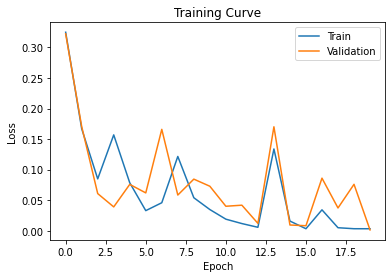

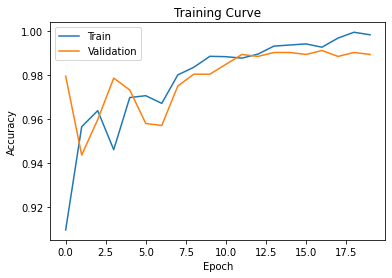

In [ ]:
# Model 3 RNN with Max pool layer out = self.fc(torch.max(out, dim=1)[0])
# h_size = 100, epochs = 20, lr = 0.001
model = RNN_max(input_size, hidden_size = 100, num_classes = 2).to(device)   
train_rnn_network(model, train, valid, batch_size = 64, num_epochs = 20, learning_rate = 1e-3)

This is a much better model with high accuracy on training and validation set.

Epoch 1; Loss 0.686064; Train Acc 0.809484; Val Acc 0.869058
Epoch 2; Loss 0.696157; Train Acc 0.522136; Val Acc 0.135426
Epoch 3; Loss 0.714602; Train Acc 0.520975; Val Acc 0.135426
Epoch 4; Loss 0.719349; Train Acc 0.521638; Val Acc 0.138117
Epoch 5; Loss 0.724272; Train Acc 0.522799; Val Acc 0.140807
Epoch 6; Loss 0.716237; Train Acc 0.522799; Val Acc 0.140807
Epoch 7; Loss 0.733201; Train Acc 0.559111; Val Acc 0.205381
Epoch 8; Loss 0.706016; Train Acc 0.749793; Val Acc 0.555157
Epoch 9; Loss 0.637129; Train Acc 0.936992; Val Acc 0.947085
Epoch 10; Loss 0.451115; Train Acc 0.900514; Val Acc 0.923767
Epoch 11; Loss 0.479380; Train Acc 0.926712; Val Acc 0.886099
Epoch 12; Loss 0.337758; Train Acc 0.941635; Val Acc 0.911211
Epoch 13; Loss 0.515658; Train Acc 0.940640; Val Acc 0.942601
Epoch 14; Loss 0.321570; Train Acc 0.948101; Val Acc 0.948879
Epoch 15; Loss 0.471482; Train Acc 0.950754; Val Acc 0.944395
Epoch 16; Loss 0.248621; Train Acc 0.952578; Val Acc 0.947085
Epoch 17; Loss 0.

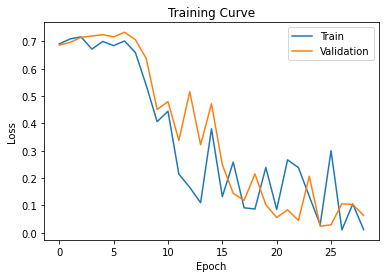

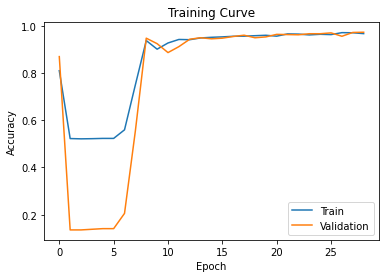

In [ ]:
# Model 4 RNN with Max pool layer out = self.fc(torch.max(out, dim=1)[0])
# h_size = 150, epochs = 29, lr = 0.00001 and batch = 32
model = RNN_con(input_size, hidden_size = 150, num_classes = 2).to(device)   
train_rnn_network(model, train, valid, batch_size = 32, num_epochs = 29, learning_rate = 1e-5)

Here the model did better but the validation score is mostly higher than the training score indicating some kind of noise in the dataset. 

Epoch 1; Loss 0.646910; Train Acc 0.480020; Val Acc 0.865471
Epoch 2; Loss 0.686975; Train Acc 0.480020; Val Acc 0.865471
Epoch 3; Loss 0.685377; Train Acc 0.794230; Val Acc 0.932735
Epoch 4; Loss 0.687352; Train Acc 0.878793; Val Acc 0.801794
Epoch 5; Loss 0.700811; Train Acc 0.634886; Val Acc 0.364126
Epoch 6; Loss 0.700889; Train Acc 0.542033; Val Acc 0.177578
Epoch 7; Loss 0.709574; Train Acc 0.544188; Val Acc 0.184753
Epoch 8; Loss 0.720102; Train Acc 0.561764; Val Acc 0.212556
Epoch 9; Loss 0.712538; Train Acc 0.617145; Val Acc 0.318386
Epoch 10; Loss 0.700286; Train Acc 0.771514; Val Acc 0.601794
Epoch 11; Loss 0.667170; Train Acc 0.933013; Val Acc 0.901345
Epoch 12; Loss 0.532416; Train Acc 0.930360; Val Acc 0.960538
Epoch 13; Loss 0.419085; Train Acc 0.907975; Val Acc 0.962332
Epoch 14; Loss 0.468362; Train Acc 0.909799; Val Acc 0.963229
Epoch 15; Loss 0.562002; Train Acc 0.916432; Val Acc 0.967713
Epoch 16; Loss 0.330234; Train Acc 0.929033; Val Acc 0.971300
Epoch 17; Loss 0.

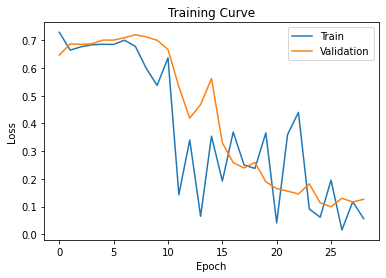

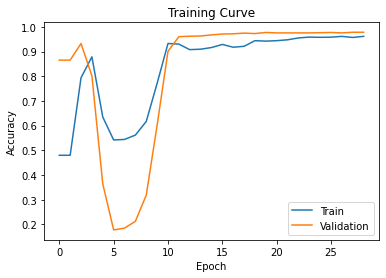

In [ ]:
# Model 5 GRU with Max pool layer out = self.fc(torch.max(out, dim=1)[0])
# h_size = 150, epochs = 29, lr = 0.00001 and batch = 32
model = GRU(input_size, hidden_size = 150, num_classes = 2).to(device)   
train_rnn_network(model, train, valid, batch_size = 32, num_epochs = 29, learning_rate = 1e-5)

In the GRU model the validation score is constantly higher than the training set.

Epoch 1; Loss 0.051620; Train Acc 0.944619; Val Acc 0.982960
Epoch 2; Loss 0.269128; Train Acc 0.971978; Val Acc 0.981166
Epoch 3; Loss 0.126402; Train Acc 0.978776; Val Acc 0.988341
Epoch 4; Loss 0.027780; Train Acc 0.988891; Val Acc 0.979372
Epoch 5; Loss 0.017407; Train Acc 0.995523; Val Acc 0.987444
Epoch 6; Loss 0.005641; Train Acc 0.997513; Val Acc 0.983857
Epoch 7; Loss 0.068951; Train Acc 0.997347; Val Acc 0.982960
Epoch 8; Loss 0.000564; Train Acc 1.000000; Val Acc 0.990135
Epoch 9; Loss 0.615012; Train Acc 1.000000; Val Acc 0.990135
Epoch 10; Loss 0.322539; Train Acc 1.000000; Val Acc 0.991031
Epoch 11; Loss 0.009668; Train Acc 1.000000; Val Acc 0.990135
Epoch 12; Loss 0.000613; Train Acc 1.000000; Val Acc 0.990135
Epoch 13; Loss 0.000158; Train Acc 1.000000; Val Acc 0.990135
Epoch 14; Loss 0.407993; Train Acc 1.000000; Val Acc 0.990135
Epoch 15; Loss 0.855113; Train Acc 1.000000; Val Acc 0.990135
Epoch 16; Loss 0.023548; Train Acc 1.000000; Val Acc 0.990135
Epoch 17; Loss 0.

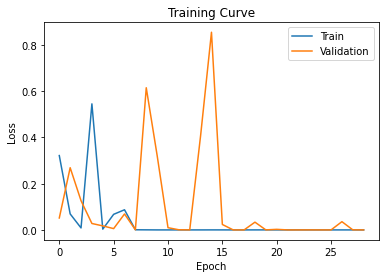

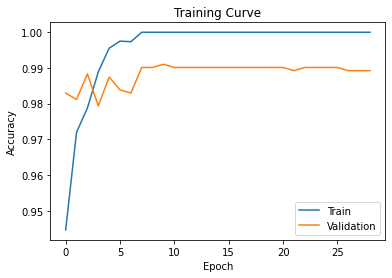

In [ ]:
# Model 6 LSTM with Max pool layer out = self.fc(torch.max(out, dim=1)[0])
# h_size = 250, epochs = 29, lr = 0.001 and batch = 32
model = LSTM(input_size, hidden_size = 250, num_classes = 2).to(device)   
train_rnn_network(model, train, valid, batch_size = 32, num_epochs = 29, learning_rate = 1e-3)

Here the model overfit due to high learning rate

Epoch 1; Loss 0.180206; Train Acc 0.937324; Val Acc 0.970404
Epoch 2; Loss 0.078620; Train Acc 0.952247; Val Acc 0.977578
Epoch 3; Loss 0.267042; Train Acc 0.972310; Val Acc 0.973991
Epoch 4; Loss 0.143365; Train Acc 0.977616; Val Acc 0.975785
Epoch 5; Loss 0.033305; Train Acc 0.983585; Val Acc 0.982960
Epoch 6; Loss 0.027077; Train Acc 0.989388; Val Acc 0.984753
Epoch 7; Loss 0.022343; Train Acc 0.994528; Val Acc 0.985650
Epoch 8; Loss 0.023324; Train Acc 0.992870; Val Acc 0.984753
Epoch 9; Loss 0.148046; Train Acc 0.999503; Val Acc 0.986547
Epoch 10; Loss 0.014425; Train Acc 0.998342; Val Acc 0.984753


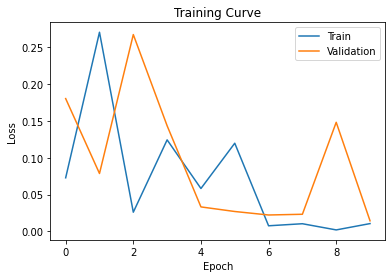

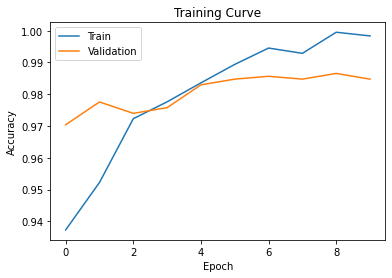

In [ ]:
# Model 7 LSTM with Max pool layer out = self.fc(torch.max(out, dim=1)[0]) and added dropout 40% to the classifiers first linear layer
# h_size = 250, epochs = 10, lr = 0.001 and batch = 32 (lstm 2)
model = LSTM_drop(input_size, hidden_size = 250, num_classes = 2).to(device)   
train_rnn_network(model, train, valid, batch_size = 32, num_epochs = 10, learning_rate = 1e-3)

Here the model did way better after adding a dropout layer. This is chosen as the best model as it has a high training and validation score and as LSTM is also overall a better model than RNN 

**BEST MODEL LINK:** https://drive.google.com/file/d/1UBzXIco3yLeagozNkkt1tLckfb5on8rR/view?usp=sharing

### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)
best_model = LSTM_drop(input_size, hidden_size = 250, num_classes = 2).to(device)
best_model_path = "/content/model_LSTM_drop"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

false_positive_rate = 1 - get_accuracy(best_model, valid_nospam, batch_size = 32)
false_negative_rate = 1 - get_accuracy(best_model, valid_spam, batch_size = 32)

print("false positive rate is:", round(false_positive_rate * 100,2),'%')
print("false negative rate is:", round(false_negative_rate * 100,2),'%')

false positive rate is: 2.69 %
false negative rate is: 6.67 %


### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**ANSWER:**

1) **False Positive**: means a message is a spam but is classified as a non-spam/ham. The impact would be that most of the sms's would be spam and can cause annoyance.

2) **False Negative**: means a message is a non-spam/ham but is classified as a spam. The impact of this would be much greater, as this could cause the person from missing important messages.

## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
best_model = LSTM_drop(input_size, hidden_size = 250, num_classes = 2).to(device)
best_model_path = "/content/model_LSTM_drop"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

test_accuracy = get_accuracy(best_model, test, batch_size = 32)
print("Test accuracy is:", test_accuracy)

Test accuracy is: 0.966786355475763


### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

best_model = LSTM_drop(input_size, hidden_size = 250, num_classes = 2).to(device)
best_model_path = "/content/model_LSTM_drop"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

false_positive_rate = 1 - get_accuracy(model, test_nospam, batch_size = 32)
false_negative_rate = 1 - get_accuracy(model, test_spam, batch_size = 32)

print("false positive rate for test dataset is:", round(false_positive_rate * 100, 2),'%')
print("false negative rate for test dataset is:", round(false_negative_rate * 100, 2),'%')

false positive rate for test dataset is: 0.93 %
false negative rate for test dataset is: 8.72 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

best_model = LSTM_drop(input_size, hidden_size = 250, num_classes = 2).to(device)
best_model_path = "/content/model_LSTM_drop"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

print(text_field.vocab.stoi)
msg_list = []
for index in range(0, len(msg)):
    msg_list.append(text_field.vocab.stoi[msg[index]])
print(msg_list)
test_message = torch.LongTensor([msg_list])
pred = best_model(test_message)
a = pred[0][1]
prob_of_spam = np.exp(float(pred[0][1])) / (np.exp(float(pred[0][0])) + np.exp(float(pred[0][1])))
print("probability of the message to be spam is:", prob_of_spam)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fb7c3b09c50>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'C': 34, 'I': 35, 'O': 36, '4': 37, 'N': 38, '7': 39, 'x': 40, '3': 41, '6': 42, 'A': 43, 'R': 44, '!': 45, '9': 46, ',': 47, 'P': 48, 'W': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'Y': 56, 'F': 57, 'G': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, '+': 73, 'J': 74, ';': 75, '(': 76, 'q': 77, '"': 78, 'Q': 79, '#': 80, '>': 81, '@': 82, '=': 83, 'ü': 84, 'Z': 85, '$': 86, 'Ü': 87, '<': 88, '‘': 89, '\x92': 90, '|': 91, '%': 92, '_': 93, '\x93': 94, '“': 95, '…': 96, '–': 97, '

### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

**ANSWER:**

 It is not an easy task. We can make a Bayesian classifier.
 firstly, we should get the count of occurances of all the words in spam 
 and ham message set respectively. Then, calculate the probability of occurance of each word in both sets. Let 's' be occurance of a word in spam and 'h' be occurance of word in ham. Using Laplace smoothing
 
 s = (# occurance in spam bag + 1) / (# of total words in spam bag) + (# of total vocabulary)
 h = (# occurance in ham bag + 1) / (# of total words in ham bag) + (# of total vocabulary)
 
 Then we can compare P1 and P2
 where: 
 
 P1 = PI(s**(# of occurance of a spam word in test message)) * (prior prob of a spam occurs) (Note: PI is the accumulated multiplication over all words in the vocabulary)
 
 P2 = PI(h**(# of occurance of a spam word in test message)) * (prior prob of a ham occurs)
 
 If P1>P2, the message is classified as spam, else, it is ham.

# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [ ]:
# install relevant libraries
!pip install fastai

In [ ]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
# # download SPAM data
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
# !unzip smsspamcollection.zip

This time we will load the data using pandas.

In [ ]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [ ]:
df_trn.shape, df_val.shape, df_test.shape

((3343, 2), (1115, 2), (1114, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [ ]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [ ]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when the first two " fights " are played , but
The problem usually starts when , during the open reality period of an hour or
The problem usually starts when a member of the Daily Mail loses their
The problem usually starts when Cr9 Love ( from his New
The problem usually starts when the player is either an unknown or a working man


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

In [ ]:
for i in range(5):
  print(lang_mod.predict("Anchit is", n_words=2))

Anchit is Good
Anchit is ok ,
Anchit is Txt
Anchit is text you
Anchit is a nice


### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [ ]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.626716,4.198765,0.314286,00:01
1,4.919044,4.186047,0.342857,00:01
2,4.485267,4.039305,0.371429,00:01
3,4.202486,4.019411,0.371429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.688574,3.950756,0.385714,00:01
1,3.634841,3.952629,0.357143,00:01
2,3.589334,3.931473,0.400000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.524023,3.912457,0.400000,00:01
1,3.505463,3.908858,0.385714,00:01
2,3.485138,3.896551,0.385714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.444623,3.878313,0.371429,00:01
1,3.415102,3.864932,0.400000,00:01
2,3.386207,3.861698,0.371429,00:01


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
xxbos xxup hey xxup girl . xxup how r u ? xxup hope u r xxup well xxup me xxup an xxup del r xxup bak ! xxup again xxup long xxup time xxup no c ! xxup give xxup me a xxup call xxup sum xxup time xxup from,ham
xxbos xxup so xxup is xxup th xxup xxunk xxup mate xxup which xxup is xxup where i xxup am ! ? ! xxup how r u xxup man ? xxup all xxup is xxup good xxup in xxup wales xxup ill b xxup back xxup xxunk . c u,ham
"xxbos xxup oh xxup rite . xxup well xxup im xxup with xxup my xxup best xxup mate xxup pete , xxup who i xxup went xxup out xxup with 4 a xxup xxunk xxup now xxup were xxup 2geva xxup again . xxup its xxup xxunk",ham
xxbos xxmaj for xxmaj the xxmaj first xxmaj time xxmaj in xxmaj the xxmaj xxunk ' xxmaj need ' ' xxmaj xxunk ' xxmaj and ' xxmaj luxury ' xxmaj are xxmaj xxunk xxmaj at xxmaj same xxmaj price xxmaj in xxmaj india .. ! !,ham
xxbos xxup xxunk xxup today xxup xxunk xxup it xxup was xxup nice 2 xxup catch xxup up xxup but xxup we xxup ave 2 xxup find xxup more xxup time xxup more xxup xxunk xxup oh xxup well xxup take xxup care c u,ham


In [ ]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3343 items)
x: TextList
xxbos xxmaj wat time ü wan today ?,xxbos xxmaj ok lor ... xxmaj or u wan me go look 4 u ?,xxbos xxmaj customer place , i wil cal u sir .,xxbos xxup hi xxup darlin xxup ive xxup just xxup got xxup back xxup and i xxup had a xxup really xxup nice xxup night xxup and xxup thanks xxup so xxup much xxup for xxup the xxup lift xxup see u xxup tomo,xxbos xxup look xxup at xxup amy xxup ure a xxup beautiful , xxup intelligent xxup woman xxup and i xxup like u a xxup lot . i xxup know u xxup dont xxup like xxup me xxup like xxup that
y: CategoryList
ham,ham,ham,ham,ham
Path: .;

Valid: LabelList (1115 items)
x: TextList
xxbos xxmaj going for xxunk you after .,xxbos xxup im xxup fine xxup babes xxup xxunk xxup been xxup up 2 xxup much xxup tho ! xxup saw xxup xxunk xxup movie xxup yest xxup its xxup quite xxup funny ! xxup want xxup 2mrw xxup afternoon ? xxup at,xxbos xxmaj dude just saw a xxunk car with its xxunk pop

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 1.10E-01


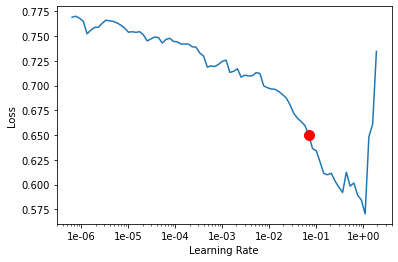

In [ ]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.414229,0.106559,0.967713,00:01
1,0.203180,0.087535,0.977578,00:01
2,0.141401,0.080654,0.976682,00:01
3,0.143445,0.078592,0.978475,00:01
4,0.127603,0.075568,0.978475,00:01


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

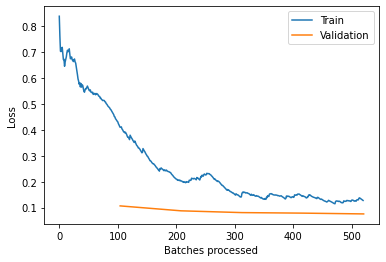

In [ ]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 2.75E-03


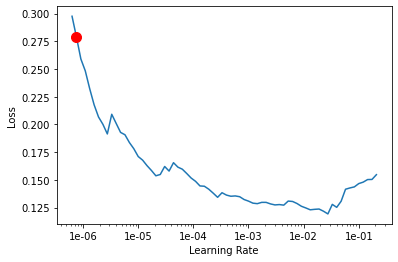

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [ ]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([9.9997e-01, 2.7530e-05]))

In [ ]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(1), tensor(1), tensor([0.2125, 0.7875]))

Next we will evaluate on all of our validation data.

In [ ]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1115, 2])

In [ ]:
valid_label

tensor([0, 0, 0,  ..., 1, 1, 1])

## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
df_test

,target,text
0,ham,"Are you sure you don't mean ""get here, we made..."
1,ham,"Today is ""song dedicated day.."" Which song wil..."
2,ham,"A few people are at the game, I'm at the mall ..."
3,ham,Take us out shopping and Mark will distract Is...
4,ham,U come n search tat vid..not finishd..
...,...,...
1109,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...
1110,spam,Someone has contacted our dating service and e...
1111,spam,England v Macedonia - dont miss the goals/team...
1112,spam,"SMSSERVICES. for yourinclusive text credits, p..."


In [ ]:
df_test['spam_pred'] = df_test['text'].apply(lambda row:str(learn_classifier.predict(row)[0]))

In [ ]:
print("Accuracy: {}".format(accuracy_score(df_test['target'],df_test['spam_pred'])))

Accuracy: 0.9829443447037702


**ANSWER:**

The ULMfit model got a higher accuracy 98% on the test data than the LSTM model which got 96%. Which is expected as the ULMfit model was pre-trained with millions of data as oposed to the LSTM model which was only trained on 6000+ sms's which is also composed of duplicate spam sms making it lack variety.


### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Taken from the scikit-learn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

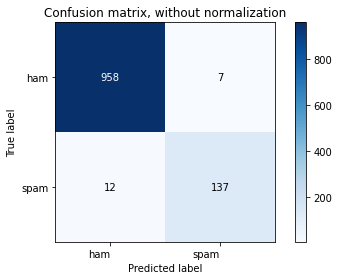

In [ ]:
# plot the confusion matrix for the test set using the ULMFit Model
plot_confusion_matrix(df_test['target'],df_test['spam_pred'],
                      classes=['ham','spam'])
plt.show()

In [ ]:
# Getting all the prediction values 
def get_all_preds(model,loader):
  all_preds = torch.tensor([])
  for message, labels in loader:
    preds = model(message[0].to(device))
    all_preds = torch.cat(
        (all_preds.to(device),preds.to(device)),dim=0
    )
  return all_preds


In [ ]:
# Getting all the labels
def get_all_labels(loader):
  all_labels = torch.tensor([])
  for message, labels in loader:
    all_labels = torch.cat(
        (all_labels,labels),dim=0
    )
  return all_labels

In [ ]:
# The best model is run on the test data to calculate the confusion matrix
data_loader = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)   

best_model = LSTM_drop(input_size, hidden_size = 250, num_classes = 2).to(device)
best_model_path = "/content/model_LSTM_drop"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

preds = get_all_preds(best_model,data_loader)
labels = get_all_labels(data_loader)

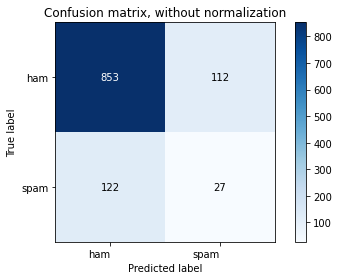

In [ ]:
# Plotting the confusion matrix
plot_confusion_matrix(labels.cpu(),preds.argmax(dim=1).cpu(),classes=['ham','spam'])
test_accuracy = get_accuracy(best_model, test, batch_size = 32)

**ANSWER:**

The ULMfit model performed much better than the LSTM model. The LSTM model failed to correctly classify most spam messages, whereas the ULMfit model did a much better job. This is because the LSTM model's dataset was imbalanced and had to be trained on duplicates of spam messages which didn't help the model to generalize very well.

## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [ ]:
msg = "machine learning is sooo cool!"
pred = learn_classifier.predict(msg)
print('The probability of the message',msg ,'being spam is', pred[2:3][0][1])
print('The probability that the message',msg,'being ham is', pred[2:3][0][0])

The probability of the message machine learning is sooo cool! being spam is tensor(0.0001)
The probability that the message machine learning is sooo cool! being ham is tensor(0.9999)


### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

In [ ]:
msg = ["Congratulations! You have won 100$ Walmart Gift Card", "UP TO 70% OFF on Clothing for Men , Women & Kids MANY MORE",
       "Urgent! Your grandson was arrested last night at Mexico. Need Bail money immediately Western Union Wire 9500$","Get 50% off with our limited-time, year-end offer on the premium ProtonVPN Plus plan.",
       "Congratulations! You recieved 3 bitcoins. Register to claim your reward"]
for m in msg:
  pred = learn_classifier.predict(m)
  print('The probability of the message',m ,'being spam is', pred[2:3][0][1])
  print('The probability that the message', m,'being ham is', pred[2:3][0][0])

The probability of the message Congratulations! You have won 100$ Walmart Gift Card being spam is tensor(0.9683)
The probability that the message Congratulations! You have won 100$ Walmart Gift Card being ham is tensor(0.0317)
The probability of the message UP TO 70% OFF on Clothing for Men , Women & Kids MANY MORE being spam is tensor(0.6176)
The probability that the message UP TO 70% OFF on Clothing for Men , Women & Kids MANY MORE being ham is tensor(0.3824)
The probability of the message Urgent! Your grandson was arrested last night at Mexico. Need Bail money immediately Western Union Wire 9500$ being spam is tensor(0.9621)
The probability that the message Urgent! Your grandson was arrested last night at Mexico. Need Bail money immediately Western Union Wire 9500$ being ham is tensor(0.0379)
The probability of the message Get 50% off with our limited-time, year-end offer on the premium ProtonVPN Plus plan. being spam is tensor(0.5875)
The probability that the message Get 50% off wi

In [ ]:
msg = ["Congratulations! You have won 100$ Walmart Gift Card", "UP TO 70% OFF on Clothing for Men , Women & Kids MANY MORE",
       "Urgent! Your grandson was arrested last night at Mexico. Need Bail money immediately Western Union Wire 9500$","Get 50% off with our limited-time, year-end offer on the premium ProtonVPN Plus plan.",
       "Congratulations! You recieved 3 bitcoins. Register to claim your reward"]

best_model = LSTM_drop(input_size, hidden_size = 250, num_classes = 2).to(device)
best_model_path = "/content/model_LSTM_drop"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

# print(text_field.vocab.stoi)
msg_list = []
for index in range(0, len(msg)):
    print(msg[index])
    msg_list.append(text_field.vocab.stoi[msg[index]])
    test_message = torch.LongTensor([msg_list])
    pred = best_model(test_message)
    a = pred[0][1]
    prob_of_spam = np.exp(float(pred[0][1])) / (np.exp(float(pred[0][0])) + np.exp(float(pred[0][1])))
    print(index+1,") The probability of the message to be spam is:", prob_of_spam)

Congratulations! You have won 100$ Walmart Gift Card
1 ) The probability of the message to be spam is: 0.0783375479202827
UP TO 70% OFF on Clothing for Men , Women & Kids MANY MORE
2 ) The probability of the message to be spam is: 0.05072879267782883
Urgent! Your grandson was arrested last night at Mexico. Need Bail money immediately Western Union Wire 9500$
3 ) The probability of the message to be spam is: 0.03317250117514608
Get 50% off with our limited-time, year-end offer on the premium ProtonVPN Plus plan.
4 ) The probability of the message to be spam is: 0.028817955016967014
Congratulations! You recieved 3 bitcoins. Register to claim your reward
5 ) The probability of the message to be spam is: 0.021275418739681296


**ANSWER:**

The ULMfit model got 4/5 correct, whereas the LSTM model performed poorly on all 5 sample sentences. Again, this is because the model is classifying most of the data as ham, which also explains why it got a high accuracy score close to ULMfit. However, the model is not good at detecting spam messages.

### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

In [ ]:
msg = ["Meghan, Duchess of Sussex seeks 'saintly rebrand","How do you guys not procrastinate?",
       'is it worth staking Ethereum?','Image Angle Detection using Neural Networks | Shiva Verma','How was your GATE 2020 result?']
for m in msg:
  pred = learn_classifier.predict(m)
  print('The probability of the message',m ,'being spam is', pred[2:3][0][1])
  print('The probability that the message', m,'being ham is', pred[2:3][0][0])

The probability of the message Meghan, Duchess of Sussex seeks 'saintly rebrand being spam is tensor(0.1411)
The probability that the message Meghan, Duchess of Sussex seeks 'saintly rebrand being ham is tensor(0.8589)
The probability of the message How do you guys not procrastinate? being spam is tensor(6.7346e-05)
The probability that the message How do you guys not procrastinate? being ham is tensor(0.9999)
The probability of the message is it worth staking Ethereum? being spam is tensor(0.0644)
The probability that the message is it worth staking Ethereum? being ham is tensor(0.9356)
The probability of the message Image Angle Detection using Neural Networks | Shiva Verma being spam is tensor(0.2246)
The probability that the message Image Angle Detection using Neural Networks | Shiva Verma being ham is tensor(0.7754)
The probability of the message How was your GATE 2020 result? being spam is tensor(0.0203)
The probability that the message How was your GATE 2020 result? being ham is 

In [ ]:
msg = ["Meghan, Duchess of Sussex seeks 'saintly rebrand","How do you guys not procrastinate?",
       'is it worth staking Ethereum?','Image Angle Detection using Neural Networks | Shiva Verma','How was your GATE 2020 result?']

best_model = LSTM_drop(input_size, hidden_size = 250, num_classes = 2).to(device)
best_model_path = "/content/model_LSTM_drop"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

# print(text_field.vocab.stoi)
msg_list = []
for index in range(0, len(msg)):
    print(msg[index])
    msg_list.append(text_field.vocab.stoi[msg[index]])
    test_message = torch.LongTensor([msg_list])
    pred = best_model(test_message)
    a = pred[0][1]
    prob_of_spam = np.exp(float(pred[0][1])) / (np.exp(float(pred[0][0])) + np.exp(float(pred[0][1])))
    print(index+1,") The probability of the message to be spam is:", prob_of_spam)

Meghan, Duchess of Sussex seeks 'saintly rebrand
1 ) The probability of the message to be spam is: 0.10414650737617259
How do you guys not procrastinate?
2 ) The probability of the message to be spam is: 0.059390177905806696
is it worth staking Ethereum?
3 ) The probability of the message to be spam is: 0.04494483289212672
Image Angle Detection using Neural Networks | Shiva Verma
4 ) The probability of the message to be spam is: 0.040053674246204936
How was your GATE 2020 result?
5 ) The probability of the message to be spam is: 0.025583391796379383


**ANSWER:**


Here the ULMfit performed very well and got all the sentences right, and the LSTM model also labeled them correctly as the model is skewed towards labeling all sentences as ham. The model could be improved if we have more varied examples of spam datasets.

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data.ipynb

[NbConvertApp] Converting notebook LAB_4_Sequential_Data.ipynb to html
[NbConvertApp] Writing 978843 bytes to LAB_4_Sequential_Data.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus